<a href="https://colab.research.google.com/github/woodychang0611/EMNIST/blob/master/EMNIST_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment
If running on colab mount google drive, otherwise use 200g drive from NCCU GPU cloud

In [1]:
import sys
import os
if ('google.colab' in sys.modules):
  from google.colab import drive
  drive.mount('/content/gdrive')
  gdrive_root = 'gdrive/My Drive/Deep_Learning/'
  dataset_path = os.path.join(gdrive_root,'Dataset')
else:
  dataset_path = '200g/Dataset'
  pass

if not os.path.exists(dataset_path):
  raise Exception(f'dataset_path "{dataset_path}"" does not exist')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load Dataset

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim
import torch.autograd
import torchvision
import torchvision.transforms
import numpy as np
from torchsummary import summary
from matplotlib import pyplot as plt
import datetime

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (1.0,))])
use_cuda = None
if torch.cuda.is_available():
  print("CUDA available")
  use_cuda = True
else:
  print ("CUDA not available")
  use_cuda = False
if os.path.exists(dataset_path):
  train_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,train =True, split="byclass",download=True)
  test_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,split="byclass", train =False)
  print (f'Dataset loaded, {train_set.__len__():,} training set, {test_set.__len__():,} testing set')
else:
  print (f'dataset_path "{dataset_path}" not found')
  exit(0)

batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print ("Load training and testing data to memory")
preload_train_data = list(enumerate(train_loader))
preload_test_data = list(enumerate(test_loader))

CUDA available
Dataset loaded, 697,932 training set, 116,323 testing set
Load training and testing data to memory


# Common Functions

In [0]:
ceriation = nn.CrossEntropyLoss()
def apply_model(model,x,target):
    x, target = torch.autograd.Variable(x), torch.autograd.Variable(target)
    out = model(x)
    loss = torch.nn.CrossEntropyLoss()(out, target)
    return out,loss
def plot_graph(name,train_loss,test_loss,acc_result):
  fig, ax = plt.subplots()
  ax.plot(train_loss,label='train loss')
  ax.plot(test_loss,label='test loss')  
  ax.plot(acc_result,label='accuracy')
  best_accuracy = np.amax(acc_result)
  best_epoch = np.argmax(acc_result)
  ax.annotate(f"\nBest Accuracy:{best_acc:.5f} at epoch {best_epoch}", 
              xy=(best_epoch, best_accuracy),
              color="blue",
              xytext=(0.2*len(acc_result), best_accuracy-0.2),
              arrowprops=dict(facecolor='blue', shrink=0.05),
              )
  ax.set(xlabel='epoch', ylabel='Loss',title=name)
  plt.legend()
  plt.show()


# Define DNN

In [0]:
#DNN
class DNN(nn.Module):
    def __init__(self,dropouts=(0,),layer_widths=(512,),lr=0.1,epoch=30):
        super(DNN, self).__init__()
        if (len(dropouts) != len(layer_widths) or len(dropouts)<=0 or len(layer_widths)<=0):
          raise Exception ("dropouts and layer_widths must have same width and greater than 0")
        self.dropouts=dropouts
        self.layer_widths = layer_widths
        self.lr =lr
        self.epoch= epoch
        input_width = 28*28
        self.fc = nn.ModuleList()
        for width in self.layer_widths:
          self.fc.append(nn.Linear(input_width, width))
          input_width = width
        self.final = nn.Linear(layer_widths[-1], 62)

    def forward(self, x):
        x = x.view(-1, 28*28)
        for dropout, fc in zip(self.dropouts,self.fc):
          x = F.dropout(x,dropout)
          x = fc(x)
          x = F.relu(x)
        x = self.final(x)
        return x
    @property
    def name(self):
        return f"DNN, Width:{self.layer_widths}, Dropout: {self.dropouts}, learning rate: {self.lr}"

2020-04-05 03:49:00.520905
model:DNN, Width:(500, 256), Dropout: (0, 0), learning rate: 0.01
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
            Linear-2                  [-1, 256]         128,256
            Linear-3                   [-1, 62]          15,934
Total params: 536,690
Trainable params: 536,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.05
Estimated Total Size (MB): 2.06
----------------------------------------------------------------
0:0.77763,1:0.81197,2:0.82554,3:0.83325,4:0.83683,5:0.84000,6:0.84222,7:0.84415,8:0.84575,9:0.84712,10:0.84842,11:0.84955,12:0.85000,13:0.85071,14:0.85123,15:0.85176,16:0.85177,17:0.85181,18:0.85155,19:0.85168,20:0.85210,21:0.85183,22:0.85177,23:0.85183,24:0.85163,25:0

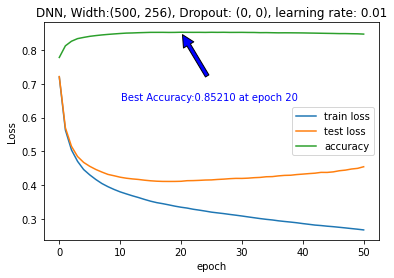

2020-04-05 03:53:23.718948
model:DNN, Width:(500, 256), Dropout: (0, 0), learning rate: 0.001
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
            Linear-2                  [-1, 256]         128,256
            Linear-3                   [-1, 62]          15,934
Total params: 536,690
Trainable params: 536,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.05
Estimated Total Size (MB): 2.06
----------------------------------------------------------------
0:0.59849,1:0.66202,2:0.69220,3:0.71357,4:0.73136,5:0.74572,6:0.75792,7:0.76799,8:0.77645,9:0.78347,10:0.78976,11:0.79509,12:0.79918,13:0.80311,14:0.80623,15:0.80943,16:0.81206,17:0.81427,18:0.81650,19:0.81863,20:0.82078,21:0.82252,22:0.82402,23:0.82568,24:0.82710,25:

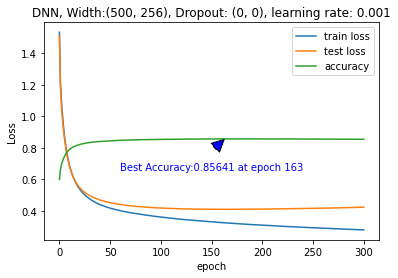

2020-04-05 04:17:46.845719
model:DNN, Width:(700, 256), Dropout: (0, 0), learning rate: 0.001
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 256]         179,456
            Linear-3                   [-1, 62]          15,934
Total params: 744,890
Trainable params: 744,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.84
Estimated Total Size (MB): 2.85
----------------------------------------------------------------
0:0.60096,1:0.66408,2:0.69452,3:0.71571,4:0.73363,5:0.74830,6:0.75976,7:0.76942,8:0.77809,9:0.78536,10:0.79129,11:0.79631,12:0.80045,13:0.80417,14:0.80745,15:0.81046,16:0.81303,17:0.81553,18:0.81769,19:0.81976,20:0.82169,21:0.82346,22:0.82476,23:0.82592,24:0.82725,25:

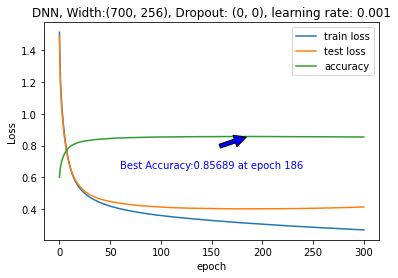

2020-04-05 04:41:44.228544
model:DNN, Width:(700, 256), Dropout: (0.05, 0), learning rate: 0.001
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 256]         179,456
            Linear-3                   [-1, 62]          15,934
Total params: 744,890
Trainable params: 744,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.84
Estimated Total Size (MB): 2.85
----------------------------------------------------------------
0:0.59794,1:0.66249,2:0.69355,3:0.71564,4:0.73422,5:0.74817,6:0.75977,7:0.76868,8:0.77673,9:0.78292,10:0.78819,11:0.79257,12:0.79674,13:0.79970,14:0.80344,15:0.80668,16:0.80956,17:0.81128,18:0.81312,19:0.81514,20:0.81736,21:0.81912,22:0.82098,23:0.82191,24:0.82376,

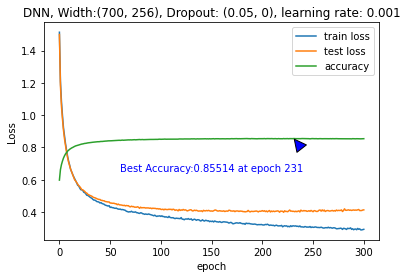

2020-04-05 05:06:13.154125
model:DNN, Width:(700, 256), Dropout: (0.1, 0), learning rate: 0.001
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 256]         179,456
            Linear-3                   [-1, 62]          15,934
Total params: 744,890
Trainable params: 744,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.84
Estimated Total Size (MB): 2.85
----------------------------------------------------------------
0:0.59452,1:0.65763,2:0.68842,3:0.70773,4:0.72594,5:0.74160,6:0.75298,7:0.76194,8:0.77057,9:0.77782,10:0.78318,11:0.78894,12:0.79276,13:0.79707,14:0.80027,15:0.80313,16:0.80619,17:0.80793,18:0.81067,19:0.81257,20:0.81446,21:0.81582,22:0.81740,23:0.81908,24:0.82035,2

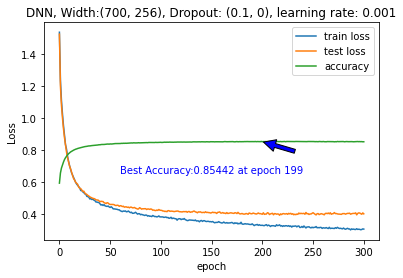

done


In [5]:
models = (
     DNN(layer_widths = (500,256,), dropouts = (0,0,),lr=0.01,epoch=50),    
     DNN(layer_widths = (500,256,), dropouts = (0,0,),lr=0.001,epoch=300),    
     DNN(layer_widths = (700,256,), dropouts = (0,0,),lr=0.001,epoch=300), 
     DNN(layer_widths = (700,256,), dropouts = (0.05,0,),lr=0.001,epoch=300), 
     DNN(layer_widths = (700,256,), dropouts = (0.1,0,),lr=0.001,epoch=300), 
    )
for model in models:
  name = model.name
  print(datetime.datetime.now())
  optimizer = torch.optim.SGD(model.parameters(), lr=model.lr, momentum=0.9)
  parameter_len = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'model:{name}')
  train_loss=[]
  test_loss=[]
  acc_result=[]
  if use_cuda:
    model.cuda()
  summary(model,(1,28,28))
  best_acc = 0
  best_epoch = 0
  for epoch in range(model.epoch+1):
    # training
    ave_loss = 0
    for batch_idx, (x, target) in preload_train_data:
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        out,loss = apply_model (model,x,target)
        ave_loss = ave_loss * 0.9 + loss.data* 0.1
        loss.backward()
        optimizer.step()
    train_loss.append(ave_loss)
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in preload_test_data:
        if use_cuda:
          x, target = x.cuda(), target.cuda()      
        out,loss = apply_model (model,x,target)        
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
    acc = correct_cnt * 1.0 / total_cnt
    print(f'{epoch}:{acc:.5f}', end=',')
    if (acc > best_acc):
      best_acc = acc
      best_epoch = epoch
    test_loss.append(ave_loss)
    acc_result.append(acc)
  print (f"\nBest Accuracy:{best_acc} at epoch {best_epoch}")  
  plot_graph(name,train_loss,test_loss,acc_result)
print("done")